# Intrinsic periodicity of the SIR system

Continuing our investigation of the Susceptible-Infected-Recovered system, 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S \\
\\
\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I \\
\\
\dot{R} = \gamma I - \mu R
$$

With non-trivial endemic equilbrium 

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\
\\
\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

General analysis of a system's stability of and approach to equilibria is beyond the scope of this notebook, and detailed discussions are available elsewhere (e.g., Keeling/Rohani Box 2.4).  In brief, one constructs the Jacobian of the system at the equilibrium points and computes its eigenvalues.  If all eigenvalues have negative real component, then the equilibrium is stable; if the dominant eigenvalues are complex conjugates, then system approaches equilibrium via damped oscillations, with damping constant equal to the real component and frequency equal to the imaginary component. This is the case for the SIR system around the non-trivial ($R_0 \gt 1$) equilibrium, with dominant eigenvalues:

$$
\Lambda = -\frac{\mu R_0}{2} \pm \frac{\sqrt{\mu^2 R_0^2 - \frac{4}{A G}}}{2} \\
\\
\text{where} \:\: A = \frac{1}{\mu (R_0 -1)} and G = \frac{1}{\mu + \gamma}
$$

In general, $\mu^2 R_0^2$ is quite small, and the intrinsic periodicity of the system is $T \approx 2 \pi \sqrt{A G}$.

### Contruct the model

The model is contructed as in notebook 05, though we will not record date of infection here. As again, we are looking at behavior around the endemic equilibrium, the same considerations of large-ish populations and long simulations apply here.

### Sanity check

The first test, as always, ensures that certain basic constraints are being obeyed by the model.

### Scientific test

The scientific test will sample a set of $(\mu, \gamma, R_0)$ tuplets and confirm that the periodicity is as expected.

### Future work

The addition of an exposed compartment with rate constant $\sigma$ should change this result, by changing the generation time $G$ to $\frac{1}{\mu + \gamma} + \frac{1}{\mu + \sigma}$


In [9]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet

import laser.core
import laser.generic
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser.generic import SIR
from laser.generic import Model
from laser.generic.newutils import ValuesMap
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator
from laser.core.utils import grid

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks


print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")

np.__version__='2.2.6'
laser.core.__version__='0.7.0'
laser.generic.__version__='0.0.0'


There will be a couple of challenges in testing here. We want to capture enough oscillations to get a stable signal but would also like to limit runtime. So aiming to sample a region in which oscillation periods will be order 1-3 years, so that we get plenty of cycles in a few decade simulation. Second is that there are lots of transient signals so we have to throw out some of the initial data. Lastly, and most importantly - the analysis above does rely on a bit of a linearization around the equilibrium point of the system, but this system is fundamentally a stochastic non-linear oscillator and is subject to lots of fun dynamics that can complicate empirically observing the fundamental periodicity.

To ameliorate these, we will: Try to start relatively close to equilibrium values of S, I, R. Use two methods to estimate frequency - "peak finding" in the time-domain, and autocorrelation spectrum in the frequency domain. And instead of looking for the period of maximum power, specifically look for a peak in the power spectrum in the vicinity of the expected period.

In [2]:
class Importation:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0:
            i_susceptible = np.nonzero(self.model.people.state == SIR.State.SUSCEPTIBLE.value)[0]
            if len(i_susceptible) > 0:
                count = min(self.count, len(i_susceptible))
                i_infect = np.random.choice(i_susceptible, size=count, replace=False)
                self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                samples = np.round(samples)
                samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                self.model.people.itimer[i_infect] = samples
                inf_by_node = np.bincount(self.model.people.nodeid[i_infect], minlength=len(self.model.nodes)).astype(self.model.nodes.S.dtype)
                self.model.nodes.S[tick + 1] -= inf_by_node
                self.model.nodes.I[tick + 1] += inf_by_node
                self.model.nodes.imports[tick] = inf_by_node
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return


In [ ]:
pop=2e5
scenario = grid(M=1, N=1, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 1
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected
scenario["R"] = 0
parameters = PropertySet(
    {"seed": 4, "nticks": 365*100, "verbose": True, "beta": 0.4, "inf_mean": 12, "cbr": 90, "importation_period": 180, "importation_count": 3}
)


birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
infdurdist = dists.exponential(scale=parameters.inf_mean)
rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
pyramid = AliasedDistribution(stable_age_dist)
survival = KaplanMeierEstimator(stable_age_dist.cumsum())


200,000 agents in 1 node(s): 100%|██████████| 36500/36500 [00:33<00:00, 1104.23it/s]


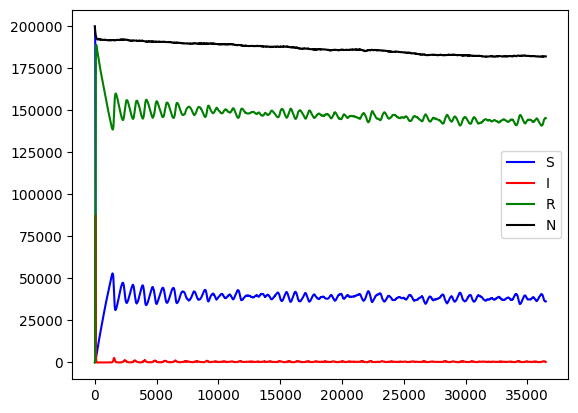

In [7]:
model = Model(scenario, parameters, birthrates=birthrate_map.values)

model.components = [
    SIR.Susceptible(model),
    SIR.Recovered(model),
    SIR.Infectious(model, infdurdist),
    Importation(model, infdurdist),
    SIR.Transmission(model, infdurdist),
    BirthsByCBR(model, birthrate_map.values, pyramid),
    MortalityByEstimator(model, estimator=survival),
]

model.run()

plt.plot(model.nodes.S, color="blue")
plt.plot(model.nodes.I, color="red")
plt.plot(model.nodes.R, color="green")
plt.plot(model.nodes.S+model.nodes.I+model.nodes.R, color="black")
plt.legend(["S", "I", "R", "N"])
plt.show()

### Sanity checks

As always, check that we haven't broken anything - S+I+R = N at all times, stocks track flows (need to have deaths by state to do this right).


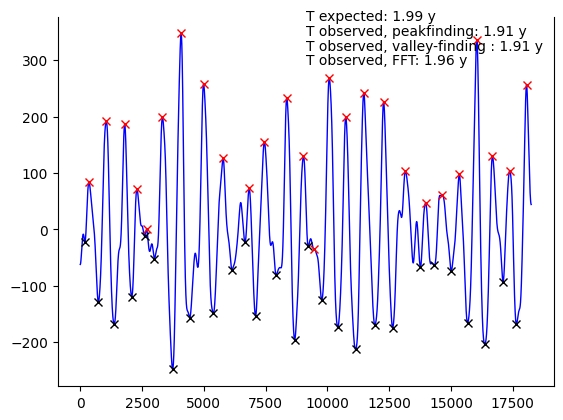

In [10]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / ((R0 - 1) * mu) / 365
G = 1 / (mu + 1 / model.params.inf_mean) / 365
T_exp = 2 * np.pi * np.sqrt(A * G)


def ID_freq_peakfinder(y0, T_exp, cutoff=18250, plot=False):
    y = y0[cutoff:]
    y = y - np.mean(y)
    y = gaussian_filter1d(y, sigma=50)
    peaks, _ = find_peaks(y, distance=T_exp * 365 / 2)
    peaks2, _ = find_peaks(-1*y, distance=T_exp * 365 / 2)
    if plot:
        plt.figure()
        plt.plot(y, 'b-', lw=1)
        plt.plot(peaks, y[peaks], "rx")
        plt.plot(peaks2, y[peaks2], "kx")
    return np.median(np.diff(peaks)) / 365, np.median(np.diff(peaks2)) / 365


T_obs_pf, T_obs_pf2 = ID_freq_peakfinder(np.squeeze(model.nodes.I), T_exp, plot=True)


def ID_freq_autocorr(y0, cutoff=18250):
    # Compute the FFT
    Y1 = np.fft.fft(y0[cutoff:] - np.mean(y0[cutoff:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance=300)
    return peaks[0] / 365


T_obs_fft = ID_freq_autocorr(np.squeeze(model.nodes.I))

plt.text(0.5, 0.99, f"T expected: {T_exp:.2f} y", transform=plt.gca().transAxes)
plt.text(0.5, 0.95, f"T observed, peakfinding: {T_obs_pf:.2f} y", transform=plt.gca().transAxes)
plt.text(0.5, 0.91, f"T observed, valley-finding : {T_obs_pf:.2f} y", transform=plt.gca().transAxes)
plt.text(0.5, 0.87, f"T observed, FFT: {T_obs_fft:.2f} y", transform=plt.gca().transAxes)
plt.gca().spines['top'].set_visible(False)
plt.show()

### Larger test suite

OK, so now we are going to replicate the above test for many values of R0 and cbr, as a scientific validity test.

This takes 5+ minutes.

In [17]:
nsims = 10
nticks = 36500
cbrs = 70 + 30 * np.random.rand(nsims)
inf_means = 50 + 50 * np.random.rand(nsims)
R0s = 5 + 10 * np.random.rand(nsims)
mu = [((1 + cbr / 1000) ** (1 / 365) - 1) for cbr in cbrs]
A = [1 / ((R0 - 1) * mu) / 365 for R0, mu in zip(R0s, mu)]
G = [1 / (mu + 1 / inf_mean) / 365 for mu, inf_mean in zip(mu, inf_means)]
T_exp = [2 * math.pi * np.sqrt(A * G) for A, G in zip(A, G)]
mycases = np.zeros((nsims, nticks))
params_df = pd.DataFrame(
    {
        "cbr": cbrs,
        "inf_mean": inf_means,
        "R0": R0s,
        "A": A,
        "G": G,
        "T_exp": T_exp,
        "mu": mu,
    }
)

pop=2e5
initial_infected = 1
mycases = np.zeros((nsims, nticks+1))


In [18]:
params_df

,cbr,inf_mean,R0,A,G,T_exp,mu
0,90.508964,90.349275,6.665553,2.036878,0.242334,4.414380,0.000237
1,81.110771,62.949359,11.092674,1.270322,0.170175,2.921356,0.000214
2,82.310983,85.107588,8.638717,1.654870,0.228948,3.867503,0.000217
3,79.510841,57.873225,13.875264,1.015059,0.156656,2.505529,0.000210
4,82.941336,99.109098,7.240022,2.011003,0.265781,4.593546,0.000218
5,79.512476,54.744742,8.765007,1.683050,0.148284,3.138884,0.000210
6,87.871836,70.080078,10.950138,1.193132,0.188944,2.983260,0.000231
7,78.577432,58.202627,10.259307,1.427604,0.157559,2.979922,0.000207
8,89.338710,77.509346,11.531469,1.109518,0.208564,3.022503,0.000234
9,93.028680,73.265490,7.143123,1.829785,0.197206,3.774328,0.000244


In [19]:
for i in range(nsims):
    row = params_df.iloc[i]
    scenario = grid(M=1, N=1, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
    parameters = PropertySet(
        {"seed": 42+i, 
         "nticks": 365*100, 
         "verbose": True, 
         "beta": row["R0"] * (row["mu"] + 1 / row["inf_mean"]), 
         "inf_mean": row["inf_mean"], 
         "cbr": row["cbr"], 
         "importation_period": 180, 
         "importation_count": 3}
    )

    scenario["I"] = initial_infected
    scenario["R"] = np.round(pop * (1 / row["R0"])).astype(np.int32)
    scenario["S"] = scenario.population - scenario["I"] - scenario["R"]

    birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
    model = Model(scenario, parameters, birthrates=birthrate_map.values)
    infdurdist = dists.exponential(scale=parameters.inf_mean)
    rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
    pyramid = AliasedDistribution(stable_age_dist := np.array(1000*np.exp(-rate_const*np.arange(89))))
    survival = KaplanMeierEstimator(stable_age_dist.cumsum())
    
    model.components = [
        SIR.Susceptible(model),
        SIR.Recovered(model),
        SIR.Infectious(model, infdurdist),
        Importation(model, infdurdist),
        SIR.Transmission(model, infdurdist),
        BirthsByCBR(model, birthrate_map.values, pyramid),
        MortalityByEstimator(model, estimator=survival),
    ]

    model.run(f"{i+1}/{nsims} simulations")
    mycases[i, :] = np.squeeze(model.nodes.I)

10/10 simulations: 100%|██████████| 36500/36500 [00:32<00:00, 1134.37it/s]


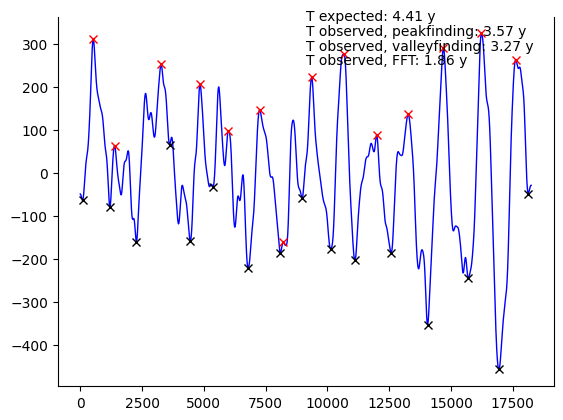

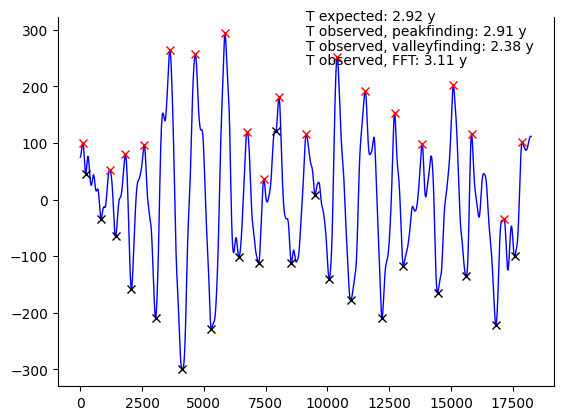

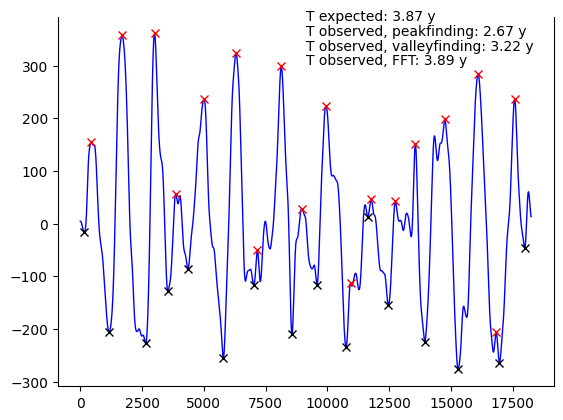

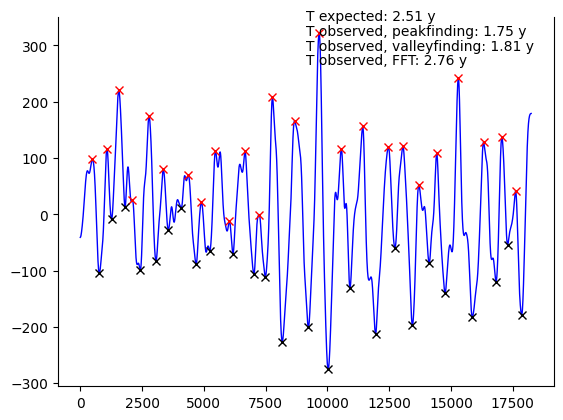

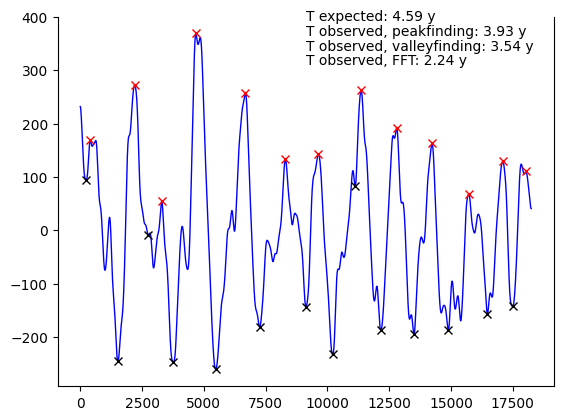

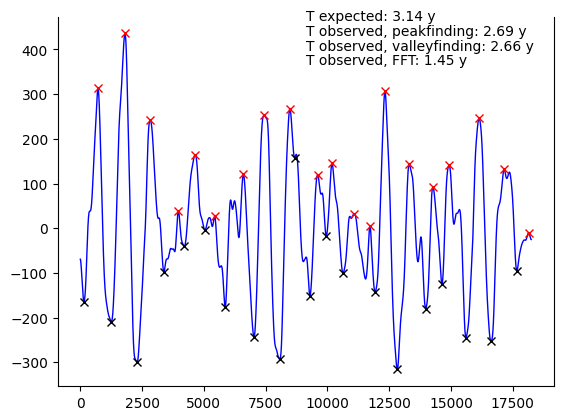

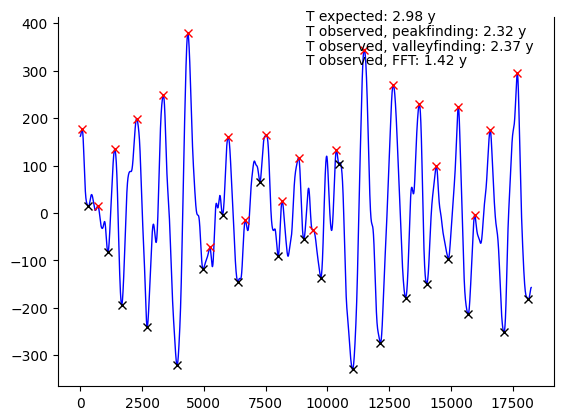

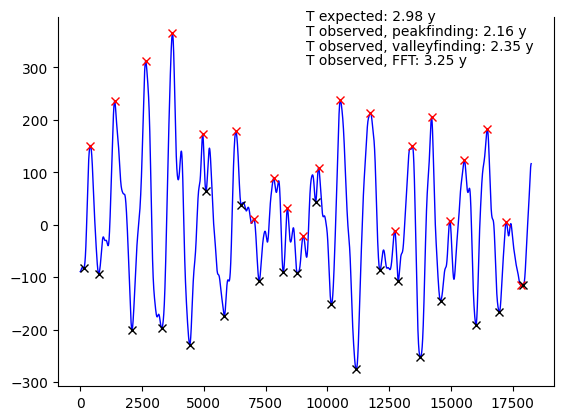

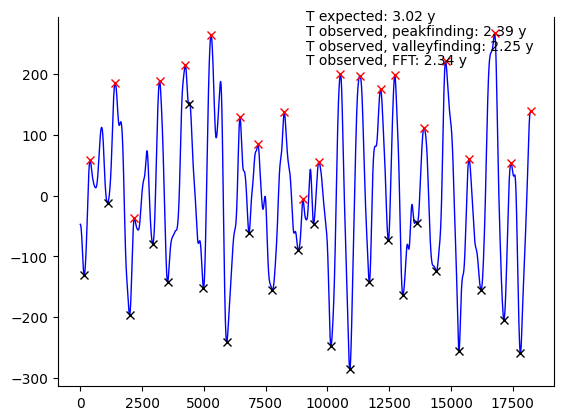

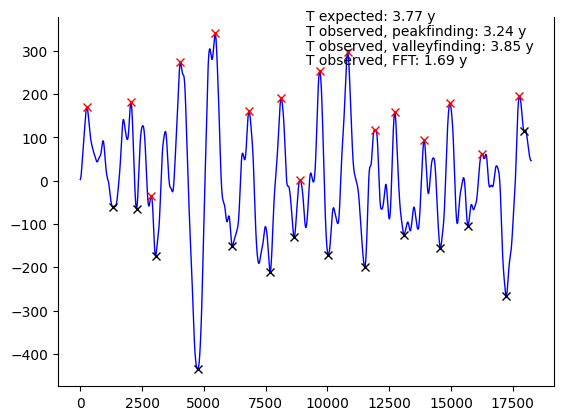

In [20]:
params_df["T_obs_peakfinder1"] = np.nan
params_df["T_obs_peakfinder2"] = np.nan
params_df["T_obs_autocorr"] = np.nan

for i in range(mycases.shape[0]):
    #plt.plot(mycases[i, :])
    pf1, pf2 = ID_freq_peakfinder(np.squeeze(mycases[i, :]), params_df.loc[i, "T_exp"], plot=True)
    params_df.loc[i, "T_obs_peakfinder1"] = pf1
    params_df.loc[i, "T_obs_peakfinder2"] = pf2
    params_df.loc[i, "T_obs_autocorr"] = ID_freq_autocorr(np.squeeze(mycases[i, :]))
    plt.text(0.5, 0.99, f"T expected: {params_df.loc[i, 'T_exp']:.2f} y", transform=plt.gca().transAxes)
    plt.text(0.5, 0.95, f"T observed, peakfinding: {params_df.loc[i, 'T_obs_peakfinder1']:.2f} y", transform=plt.gca().transAxes)
    plt.text(0.5, 0.91, f"T observed, valleyfinding: {params_df.loc[i, 'T_obs_peakfinder2']:.2f} y", transform=plt.gca().transAxes)
    plt.text(0.5, 0.87, f"T observed, FFT: {params_df.loc[i, 'T_obs_autocorr']:.2f} y", transform=plt.gca().transAxes)
    plt.gca().spines['top'].set_visible(False)

    plt.show()


In [21]:
params_df


,cbr,inf_mean,R0,A,G,T_exp,mu,T_obs_peakfinder1,T_obs_peakfinder2,T_obs_autocorr
0,90.508964,90.349275,6.665553,2.036878,0.242334,4.414380,0.000237,3.569863,3.265753,1.863014
1,81.110771,62.949359,11.092674,1.270322,0.170175,2.921356,0.000214,2.912329,2.378082,3.106849
2,82.310983,85.107588,8.638717,1.654870,0.228948,3.867503,0.000217,2.673973,3.221918,3.887671
3,79.510841,57.873225,13.875264,1.015059,0.156656,2.505529,0.000210,1.746575,1.812329,2.761644
4,82.941336,99.109098,7.240022,2.011003,0.265781,4.593546,0.000218,3.931507,3.536986,2.243836
5,79.512476,54.744742,8.765007,1.683050,0.148284,3.138884,0.000210,2.687671,2.660274,1.449315
6,87.871836,70.080078,10.950138,1.193132,0.188944,2.983260,0.000231,2.323288,2.369863,1.416438
7,78.577432,58.202627,10.259307,1.427604,0.157559,2.979922,0.000207,2.164384,2.345205,3.249315
8,89.338710,77.509346,11.531469,1.109518,0.208564,3.022503,0.000234,2.391781,2.250685,2.336986
9,93.028680,73.265490,7.143123,1.829785,0.197206,3.774328,0.000244,3.238356,3.849315,1.687671


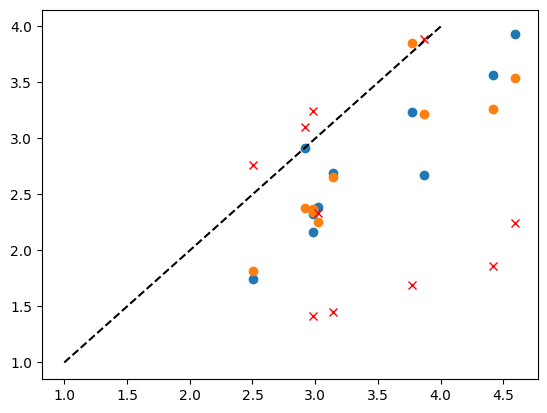

In [22]:
plt.plot(params_df["T_exp"], params_df["T_obs_peakfinder1"], "o")
plt.plot(params_df["T_exp"], params_df["T_obs_peakfinder2"], "o")
plt.plot(params_df["T_exp"], params_df["T_obs_autocorr"], "rx")
plt.plot([1, 4], [1, 4], "k--")
plt.show()